In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2, random
import PIL.Image as Image

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Detic libraries
sys.path.insert(0, 'third_party/CenterNet2/')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

## Download detector ckpt

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TwrjcUYimkI_f9z9UZXCmLztdgv31Peu' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TwrjcUYimkI_f9z9UZXCmLztdgv31Peu" -O Detic_LI_CLIP_R5021k_640b64_4x_ft4x_max-size_pomp.pth && rm -rf /tmp/cookies.txt

--2023-07-11 09:04:33--  https://docs.google.com/uc?export=download&confirm=t&id=1TwrjcUYimkI_f9z9UZXCmLztdgv31Peu
Resolving docs.google.com (docs.google.com)... 142.250.217.78, 2607:f8b0:400a:80b::200e
Connecting to docs.google.com (docs.google.com)|142.250.217.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pthk2128abnmfsou1bhldbehifle9i5q/1689066225000/00104681841894185671/*/1TwrjcUYimkI_f9z9UZXCmLztdgv31Peu?e=download&uuid=07142e55-2b9a-4e61-b816-f56a854b64ff [following]
--2023-07-11 09:04:33--  https://doc-0s-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pthk2128abnmfsou1bhldbehifle9i5q/1689066225000/00104681841894185671/*/1TwrjcUYimkI_f9z9UZXCmLztdgv31Peu?e=download&uuid=07142e55-2b9a-4e61-b816-f56a854b64ff
Resolving doc-0s-2o-docs.googleusercontent.com (doc-0s-2o-docs.googleusercontent.com)... 142.251.33.97, 2607:f8b0:40

## Download prompt ckpt

In [7]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11C8oU6cWkJdU3Q3IHaqTcbIToRLo9bMnu' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1C8oU6cWkJdU3Q3IHaqTcbIToRLo9bMnu" -O vit_b16_ep20_randaug2_unc1000_16shots_nctx16_cscFalse_ctpend_seed42.pth.tar && rm -rf /tmp/cookies.txt

--2023-07-11 11:09:40--  https://docs.google.com/uc?export=download&confirm=&id=1C8oU6cWkJdU3Q3IHaqTcbIToRLo9bMnu
Resolving docs.google.com (docs.google.com)... 142.251.33.78, 2607:f8b0:400a:805::200e
Connecting to docs.google.com (docs.google.com)|142.251.33.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uc8nql9vkl6vu5k2316ohdv8ehv9loo6/1689073725000/00104681841894185671/*/1C8oU6cWkJdU3Q3IHaqTcbIToRLo9bMnu?e=download&uuid=3c403ed0-d4b2-4a66-9ab2-4fec72942cfa [following]
--2023-07-11 11:09:41--  https://doc-0c-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uc8nql9vkl6vu5k2316ohdv8ehv9loo6/1689073725000/00104681841894185671/*/1C8oU6cWkJdU3Q3IHaqTcbIToRLo9bMnu?e=download&uuid=3c403ed0-d4b2-4a66-9ab2-4fec72942cfa
Resolving doc-0c-2o-docs.googleusercontent.com (doc-0c-2o-docs.googleusercontent.com)... 142.251.33.65, 2607:f8b0:400a:

## Build the detector and download our pretrained weights

In [2]:
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("configs/Detic_LI_CLIP_R5021k_640b64_4x_ft4x_max-size_pomp_cross_datasets.yaml")
cfg.MODEL.WEIGHTS = 'Detic_LI_CLIP_R5021k_640b64_4x_ft4x_max-size_pomp.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
# cfg.MODEL.DEVICE='cpu' # uncomment this to use cpu-only mode.
predictor = DefaultPredictor(cfg)

[07/11 11:04:39 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                       | Names in Checkpoint                                                                                                                                                        | Shapes                                                                 |
|:-----------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------|
| backbone.bottom_up.base.bn1.*                        | backbone.bottom_up.base.bn1.{bias,running_mean,running_var,weight}                                                                                                         | (64,) (64,) (64,) (64,)                                                |
| ba

## Download a sample image and display. Replace path here to try your own images!

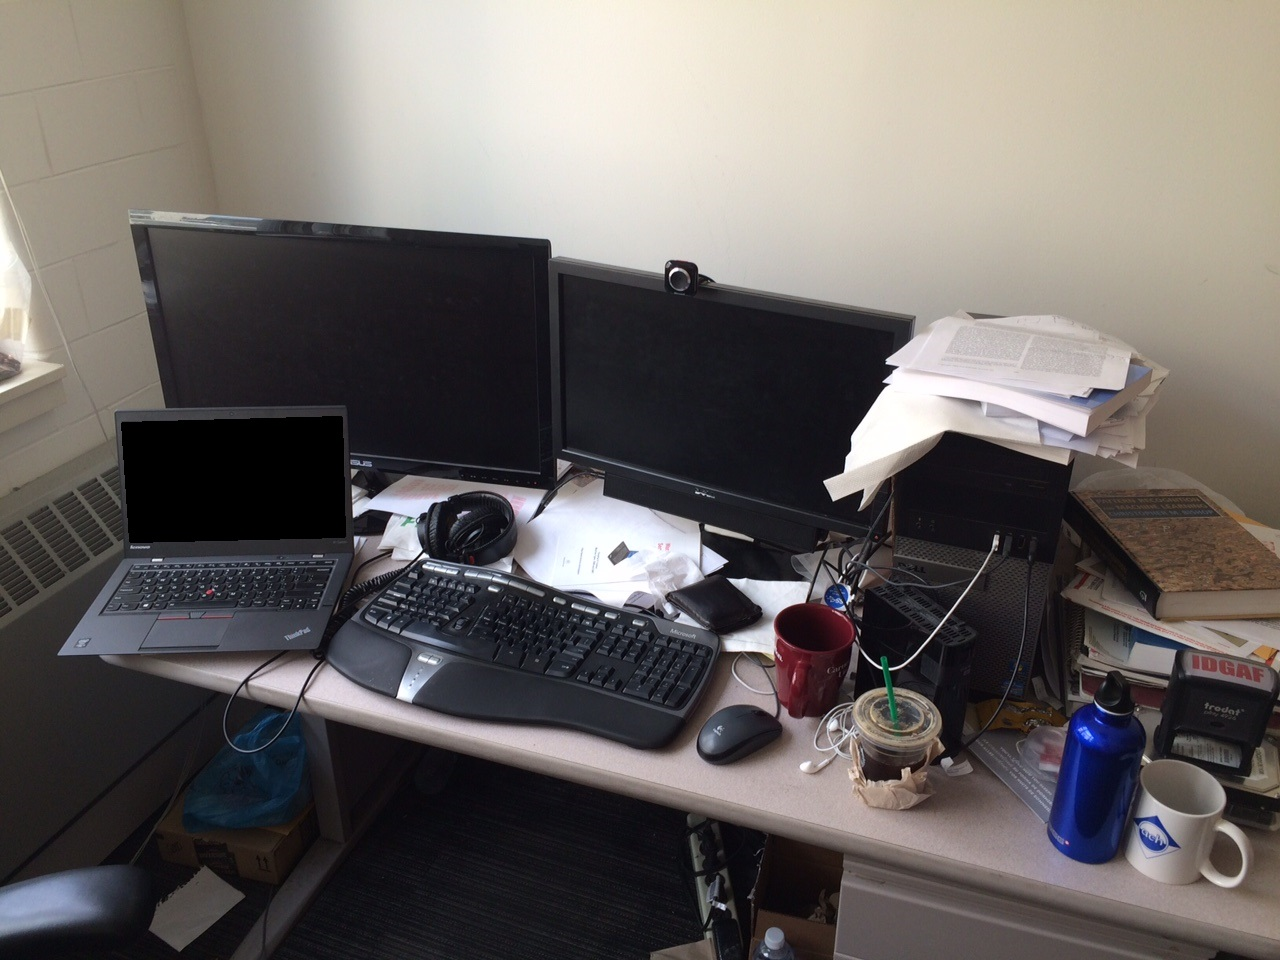

In [4]:
!wget https://web.eecs.umich.edu/~fouhey/fun/desk/desk.jpg
im = cv2.imread("./desk.jpg")
display(Image.open("./desk.jpg"))

## Setup the model's vocabulary using build-in datasets

In [26]:
BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_pomp+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_pomp+cnamefix.npy',
    'coco': 'datasets/metadata/coco_clip_pomp+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'coco': 'coco_2017_val',
}

vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_pomp+cname.npy


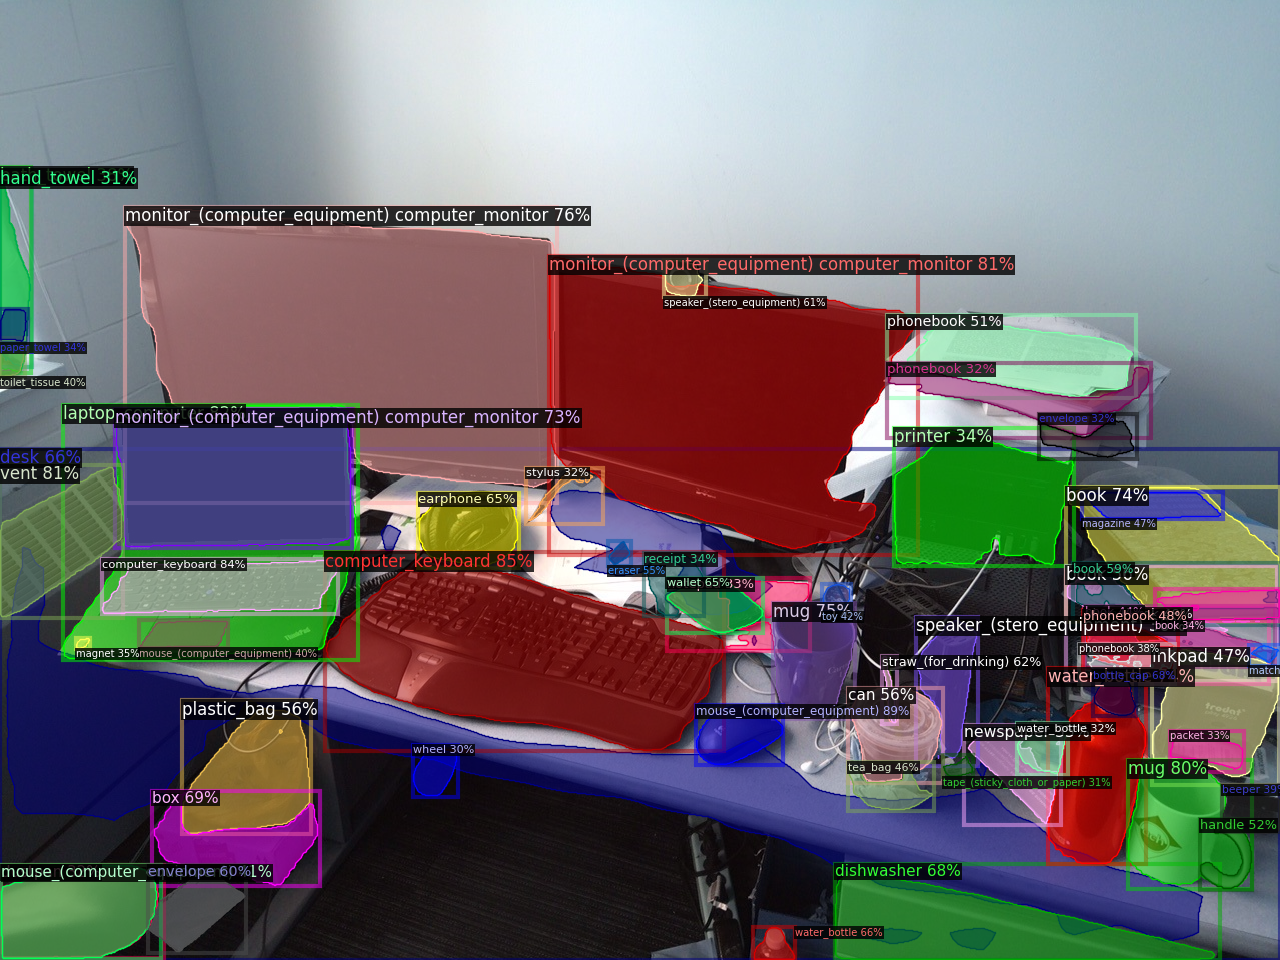

In [27]:
# Run model and show results
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
display(Image.fromarray(out.get_image()[:, :, ::-1]))

## Change the model's vocabulary to a customized one and get their word-embedding 

In [41]:
import torch
import torch.nn as nn

class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

device = 'cuda'
ckpt = torch.load('vit_b16_ep20_randaug2_unc1000_16shots_nctx16_cscFalse_ctpend_seed42.pth.tar', map_location='cpu')
ctx = ckpt["state_dict"]['ctx'].to(device)
n_ctx = ctx.size(0)

import clip
print('Loading CLIP')
model, preprocess = clip.load('ViT-B/16', device=device)
text_encoder = TextEncoder(model)

cat_names = ['headphone', 'webcam', 'paper', 'coffee'] # Change here to try your own vocabularies!

dtype = model.dtype
classnames = [name.replace("_", " ") for name in cat_names]
prompt_prefix = " ".join(["X"] * n_ctx)
prompts = [prompt_prefix + " " + name + "." for name in classnames]
tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).int().to(device)

with torch.no_grad():
    embedding = model.token_embedding(tokenized_prompts).type(dtype)
    prefix = embedding[:, :1, :]
    suffix = embedding[:, 1 + n_ctx:, :]
    ctx = ctx.unsqueeze(0).expand(len(cat_names), -1, -1)

    prompts = torch.cat(
        [
            prefix,  # (n_cls, 1, dim)
            ctx,  # (n_cls, n_ctx, dim)
            suffix,  # (n_cls, *, dim)
        ],
        dim=1,
    )
    text_features = text_encoder(prompts, tokenized_prompts)

vocabulary = 'custom'
metadata = MetadataCatalog.get("__unused")
metadata.thing_classes = ['headphone', 'webcam', 'paper', 'coffee'] # Change here to try your own vocabularies!
classifier = text_features.t().float()
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)
# Reset visualization threshold
output_score_threshold = 0.3
for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

Loading CLIP


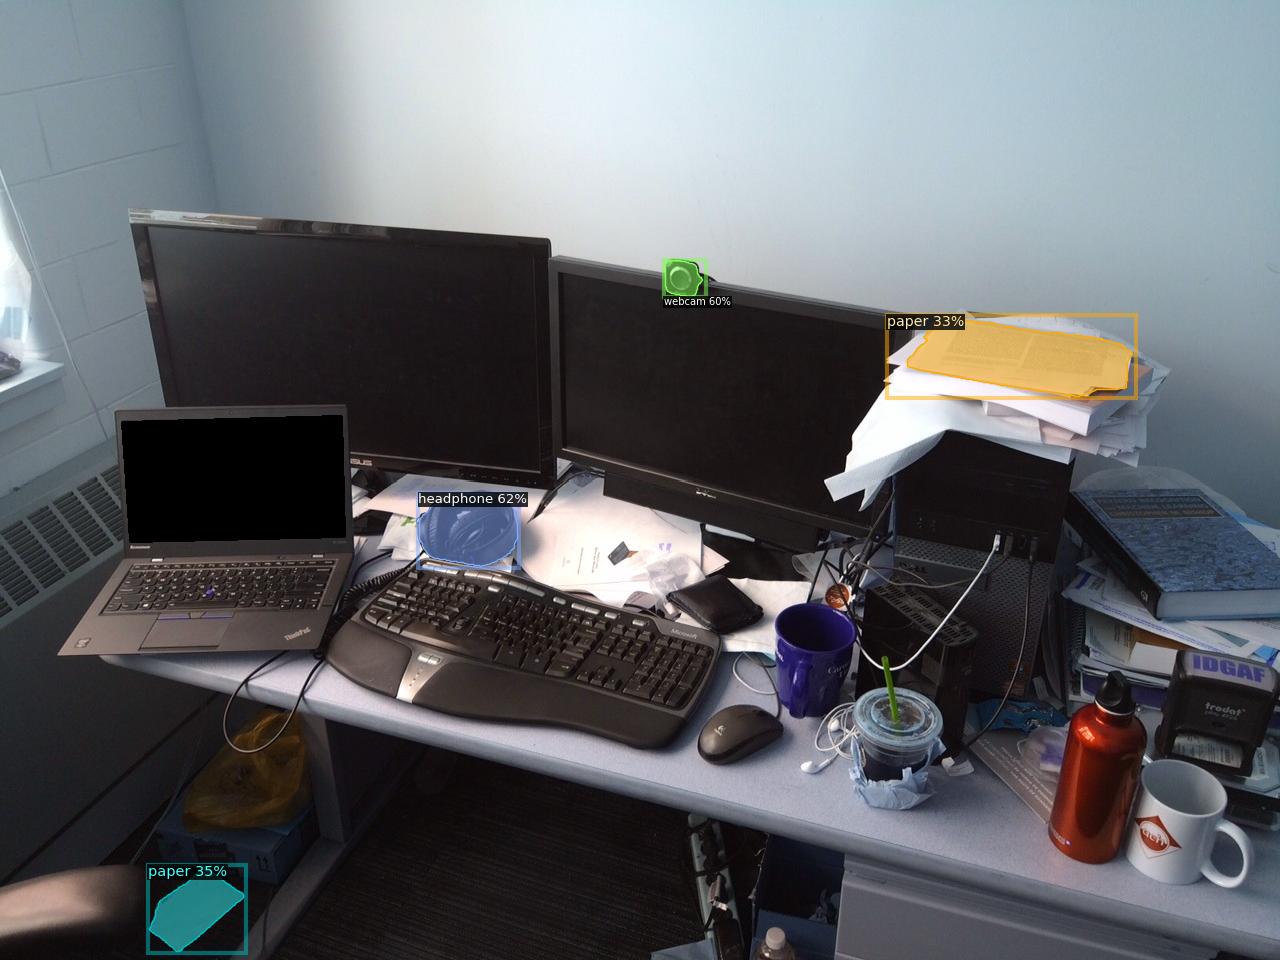

In [42]:
# Run model and show results
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
display(Image.fromarray(out.get_image()[:, :, ::-1]))